# MSBA 446 - Homework 3

## Predicting Stock Price using RNNs

In this homework assignment, your task is to develop recurrent neural network models to predict the stock price of a company of your choice. The goal is to use stock price data (open, high, low, and close data) from the prior 60 days to predict the close price of the stock in 5 days.  

First, follow the steps below to download ~15 years of historical data on the stock price of your favorite company. 

1. Go to [Yahoo Finance](https://finance.yahoo.com/).
2. Enter a stock symbol into the search field (e.g., AAPL for Apple).
3. Select it in the search results to view it.
4. Click Historical Data.
5. For the Time Period, please enter 01.01.2005 to 09.22.2020.
6. Make sure the Frequency is Daily.
6. Click Apply.
7. Click Download.

For this assignment, you are free to choose any company you like as long as it has 15 years of data (from 01.01.2005 to 09.22.2020). Examples of such companies include: Apple (AAPL), Google (GOOG), Amazon (AMZN), Nvidia (NVDA), Intel (INTC), Microsoft (MSFT), Adobe (ADBE), Netflix (NFLX), etc. You can also choose an ETF, such as the S&P 500 ETF (SPY).  


After you downloaded the historical stock data for a company of your choice, open the `.csv` file with Excel. You should be able to see seven columns: Date, Open, High, Low, Close, Adj Close, Volume.

You should also have 3958 rows in your dataset. The first row contains the headers, and the remaining 3957 rows contain daily stock prices. Note that stock prices are recorded on business days only (not weekends), so the first data point corresponds to 1.3.2005. 

If everything looks good, close your Excel file and upload the `.csv` file on your Google Drive, so you can easily import it to your Colab Notebook.

## Importing the dataset

Mount your drive using the code below.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Mounted at /content/drive


Replace the directory below with the path where your dataset is located. 

In [ ]:
# Define the directory where your ".csv" file resides on your google drive
# My path is the following (your path will be different): 
fname = '/content/drive/My Drive/Third Sem/MSBA 446: Machine Learning & Artificial Intelligence in Business Analytics/Homework/HW3/Data/NFLX.csv'



Run the code block below to read the data and seperate header from numeric data lines.

In [ ]:
f = open(fname)
data = f.read()
f.close()

data_lines = data.split('\n')     # Each line is 1 recording
header = data_lines[0].split(',') # Variable names are separated by commas
lines = data_lines[1:3958]        # Drop first line (it's a header)

print(header)
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
3957


Let's convert all of these 3,957 lines of data into a Numpy array:

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), 4))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:5]]
    float_data[i, :] = values
print(float_data.shape)
# Note that we only keep the following 4 columns: Open, High, Low, Close

(3957, 4)


You can plot the daily closing price of your stock over time as follows. **Note that the closing price is Column 3 in your dataset (columns are indexed 0, 1, 2, and 3). The dataset is named `float_data`.**

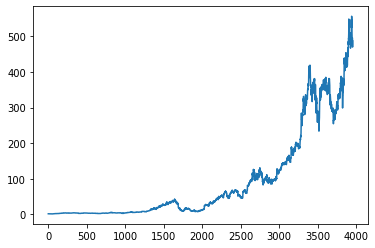

In [ ]:
from matplotlib import pyplot as plt

close = float_data[:, 3]  # index 3 is close price
plt.plot(range(len(close)), close)

## Input normalization

Since the stock price data (Open, High, Low, Close) are positive numbers, we can divide each column by it's maximum value to make the values between 0 and 1. 

In [ ]:
float_data /= float_data.max(axis=0)

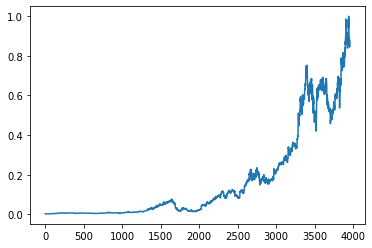

In [ ]:

close1 = float_data[:, 3]  # index 3 is close price
plt.plot(range(len(close1)), close1)

In [ ]:
float_data # ['Open', 'High', 'Low', 'Close']

array([[0.00316913, 0.00312842, 0.00306253, 0.00305967],
       [0.00299809, 0.00296704, 0.00299076, 0.00299293],
       [0.00295282, 0.00291489, 0.00294822, 0.00287485],
       ...,
       [0.83657879, 0.83146497, 0.86210617, 0.84484776],
       [0.83191314, 0.83320298, 0.85341573, 0.8444165 ],
       [0.82342691, 0.84776753, 0.867782  , 0.87566259]])

## Data generator

Similar to the Temperature Forecasting Example, we will need a data generator to automatically create batches of training, validation, and test data. We can use the same data generator function here (I copied it below).

The exact formulation of our problem is the following: given stock price data going as far back as `lookback` timesteps (a timestep is 1 day) and sampled every `steps` timesteps, can we predict the stock price in `delay` timesteps? In other words, given stock price data (Open, High, Low, Close) of the past 60 days, sampled every day, we aim to predict the close price in 5 days.

We have 3957 days worth of stock data. Please use the first 2000 days as training data, the next 1000 days as validation data, and the remaining days as test data. Please use `batch_size` of 64. 

In [ ]:
import numpy as np
 
def generator(data, lookback, delay, min_index, max_index, shuffle, batch_size, step, target_index):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    # Out dara generator will generate data indefinitely, so we will have to tell Keras
    # how many batches constitute an epoch ('steps_per_epoch' and 'validation_steps' in model.fit)
    while 1:
        # For the training set (shuffle=True), randomly choose points in time
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        # For the validation and test sets, choose batches of timesteps (in chronological order)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # Batch size
                           lookback // step, # Floor division (e.g., 5//2=2)
                           data.shape[-1]))  # Number of columns in data
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets

## Question 1 (40 pts)

First, create instances of the data generator as `train_gen`, `val_gen`, and `test_gen`.

Then, develop a recurrent neural network with one `SimpleRNN` layer. For this question, include 128 units in the `SimpleRNN` layer. 

Compile this model using the `Adam` optimizer and change the learning rate to `0.0001`. Use the appropriate loss function for this problem. During the training process, follow mean absolute percentage error or the `mape` metric on the train and validation sets. This will give you the percentage error for your stock price predictions. 

Train your RNN model for 50 epochs. Given that our data generator creates batches of data indefinitely, we will have to tell Keras how many training (validation) batches constitute one training (validation) epoch. To do so, use `steps_per_epoch=20` and `validation_steps=14`. 

Evaluate your trained RNN model on the test set. In `model.evaluate`, use `steps=14` to designate 14 batches of data as one test epoch. What is the mean absolute percentage error on the test set? 

In [ ]:
lookback = 60
step = 1
delay = 5
batch_size = 64
target_index = 3 # Predicting close price

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size,
                      target_index=target_index)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=2001,
                    max_index=3000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size,
                    target_index=target_index)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=3001,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size,
                     target_index=target_index)


# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (3000 - 2001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 3001 - lookback) // batch_size


print(val_steps)
print(test_steps)

14
14


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model1 = models.Sequential()
model1.add(layers.SimpleRNN(128))
model1.add(layers.Dense(1))


model1.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.0001),  metrics=['mape'])


model1_history = model1.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps = 14)

Epoch 1/50
20/20 [==============================] - 1s 52ms/step - loss: 2.2068e-04 - mape: 81.5354 - val_loss: 6.1343e-04 - val_mape: 12.8955
Epoch 2/50
20/20 [==============================] - 1s 32ms/step - loss: 2.2989e-05 - mape: 19.2908 - val_loss: 4.4619e-04 - val_mape: 11.0193
Epoch 3/50
20/20 [==============================] - 1s 35ms/step - loss: 1.8281e-05 - mape: 14.8826 - val_loss: 3.4396e-04 - val_mape: 10.0159
Epoch 4/50
20/20 [==============================] - 1s 32ms/step - loss: 1.5219e-05 - mape: 12.6120 - val_loss: 4.2601e-04 - val_mape: 11.6471
Epoch 5/50
20/20 [==============================] - 1s 32ms/step - loss: 1.3188e-05 - mape: 12.0690 - val_loss: 3.3401e-04 - val_mape: 9.9915
Epoch 6/50
20/20 [==============================] - 1s 32ms/step - loss: 1.2572e-05 - mape: 11.7531 - val_loss: 3.0741e-04 - val_mape: 9.6690
Epoch 7/50
20/20 [==============================] - 1s 31ms/step - loss: 1.1566e-05 - mape: 11.6244 - val_loss: 2.6704e-04 - val_mape: 9.0311
Ep

In [ ]:
model1.evaluate(test_gen, steps=14)

14/14 [==============================] - 0s 13ms/step - loss: 0.0182 - mape: 20.0083


[0.01822907291352749, 20.00826644897461]

Mean Absolute Percentage Error of the test set is **20.0083**


## Question 2 (40 pts)

Develop a recurrent neural network with one `LSTM` layer. For this question, include 128 units in the `LSTM` layer. 

Compile this model using the `Adam` optimizer and change the learning rate to `0.0001`. Use the appropriate loss function for this problem. During the training process, follow mean absolute percentage error or the `mape` metric on the train and validation sets. This will give you the percentage error for your stock price predictions. 

Train your LSTM model for 50 epochs. Given that our data generator creates batches of data indefinitely, we will have to tell Keras how many training (validation) batches constitute one training (validation) epoch. To do so, use `steps_per_epoch=20` and `validation_steps=14`. 

Evaluate your trained LSTM model on the test set. In `model.evaluate`, use `steps=14` to designate 14 batches of data as one test epoch. What is the mean absolute percentage error on the test set? 

In [ ]:
model2 = models.Sequential()
model2.add(layers.LSTM(128, input_shape=(lookback // step, 4)))
model2.add(layers.Dense(1))

model2.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.0001),  metrics=['mape'])


model2_history = model2.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)



Epoch 1/50
20/20 [==============================] - 3s 137ms/step - loss: 2.7594e-04 - mape: 88.9370 - val_loss: 0.0046 - val_mape: 44.9093
Epoch 2/50
20/20 [==============================] - 3s 159ms/step - loss: 9.7148e-05 - mape: 86.3286 - val_loss: 0.0024 - val_mape: 33.4708
Epoch 3/50
20/20 [==============================] - 4s 207ms/step - loss: 2.6911e-05 - mape: 34.5630 - val_loss: 3.2699e-04 - val_mape: 10.7793
Epoch 4/50
20/20 [==============================] - 5s 233ms/step - loss: 9.4309e-06 - mape: 11.5153 - val_loss: 1.5801e-04 - val_mape: 7.5298
Epoch 5/50
20/20 [==============================] - 3s 130ms/step - loss: 1.0751e-05 - mape: 10.0240 - val_loss: 1.6076e-04 - val_mape: 7.6351
Epoch 6/50
20/20 [==============================] - 2s 113ms/step - loss: 9.1858e-06 - mape: 9.8958 - val_loss: 1.6155e-04 - val_mape: 7.6296
Epoch 7/50
20/20 [==============================] - 2s 116ms/step - loss: 7.0985e-06 - mape: 9.5781 - val_loss: 1.5536e-04 - val_mape: 7.4705
Epoch 

In [ ]:
model2.evaluate(test_gen, steps=14)

14/14 [==============================] - 0s 33ms/step - loss: 0.0029 - mape: 7.1322


[0.0029249440412968397, 7.132241249084473]

Mean Absolute Percentage Error of the test set is **7.1322**

## Question 3 (20 pts)

Your goal in this question is to employ your deep learning knowledge to improve your LSTM model. You can play with hyperparameters, stack LSTM layers, add dropout and recurrent dropout, alter the learning rate, try another optimizer such as `rmsprop`, and anything else that you think might help improve (i.e., decrease) the percentage error of your model. This is an open-ended question that aims to give you some experience with training a good deep learning model for a real-world problem. What you do in this exercise is called 'hyperparameter tuning'; this is usually the most time-consuming and the most expensive part of a deep learning project. In a sense, deep learning is babysitting a number of hyperparameters. 

You do not need to show all of your work here. Please only include one model as your final model here. Explain (in words) what were some of the things that you tried and whether they were helpful to decrease the MAPE. 

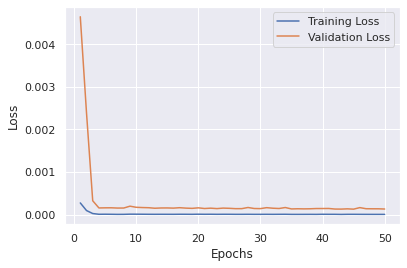

In [ ]:
import seaborn as sns
sns.set()

train_loss2 = model2_history.history['loss']
train_mape2 = model2_history.history['mape']
val_loss2 = model2_history.history['val_loss']
val_mape2 = model2_history.history['val_mape']

epochs = range(1, len(train_loss2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

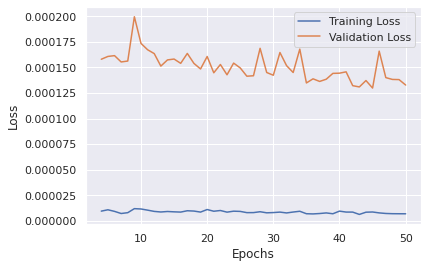

In [ ]:
plt.plot(epochs[3: ], train_loss2[3: ], label = 'Training Loss')
plt.plot(epochs[3: ], val_loss2[3: ], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

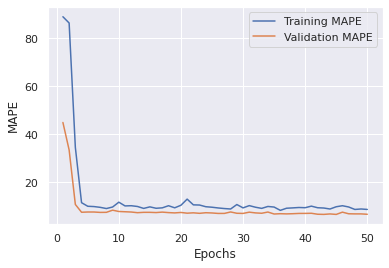

In [ ]:
plt.plot(epochs, train_mape2, label = 'Training MAPE')
plt.plot(epochs, val_mape2, label = 'Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

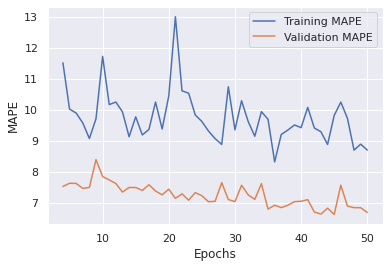

In [ ]:
plt.plot(epochs[3:], train_mape2[3:], label = 'Training MAPE')
plt.plot(epochs[3:], val_mape2[3:], label = 'Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

I do not think that the model is overfitting because training and validation loss do not diverge. They are still converging but very slowly. The model is suffering from underfitting. One way to solve this issue is adding more hidden layers and increasing number of neurons in the network. So I will try that. 



In [ ]:
model3 = models.Sequential()
model3.add(layers.LSTM(128, return_sequences=True, input_shape=(lookback // step, 4)))
model3.add(layers.LSTM(128, return_sequences=True))
model3.add(layers.LSTM(128))

model3.add(layers.Dense(1))

model3.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001),  metrics=['mape'])


model3_history = model3.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)


Epoch 1/50
20/20 [==============================] - 11s 537ms/step - loss: 0.0013 - mape: 167.5538 - val_loss: 0.0041 - val_mape: 49.5114
Epoch 2/50
20/20 [==============================] - 9s 460ms/step - loss: 1.0519e-04 - mape: 86.4002 - val_loss: 0.0021 - val_mape: 34.3023
Epoch 3/50
20/20 [==============================] - 9s 459ms/step - loss: 1.2622e-04 - mape: 101.3061 - val_loss: 0.0015 - val_mape: 28.1270
Epoch 4/50
20/20 [==============================] - 9s 452ms/step - loss: 9.5023e-05 - mape: 85.8233 - val_loss: 0.0054 - val_mape: 55.6530
Epoch 5/50
20/20 [==============================] - 9s 459ms/step - loss: 1.0501e-04 - mape: 84.9104 - val_loss: 0.0025 - val_mape: 37.7788
Epoch 6/50
20/20 [==============================] - 9s 466ms/step - loss: 8.7828e-05 - mape: 64.2028 - val_loss: 3.5447e-04 - val_mape: 13.1518
Epoch 7/50
20/20 [==============================] - 9s 463ms/step - loss: 7.5629e-05 - mape: 74.3523 - val_loss: 0.0039 - val_mape: 45.5996
Epoch 8/50
20/20 

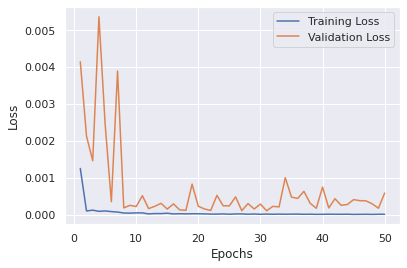

In [ ]:
import seaborn as sns
sns.set()

model = model3
model_history = model3_history


train_loss = model_history.history['loss']
train_mape = model_history.history['mape']
val_loss = model_history.history['val_loss']
val_mape = model_history.history['val_mape']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs[: ], train_loss[: ], label = 'Training Loss')
plt.plot(epochs[: ], val_loss[: ], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

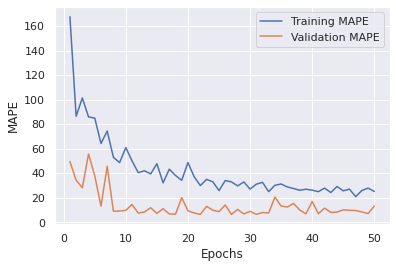

In [ ]:
plt.plot(epochs[:], train_mape[:], label = 'Training MAPE')
plt.plot(epochs[:], val_mape[:], label = 'Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

In [ ]:
model.evaluate(test_gen, steps=14)

14/14 [==============================] - 2s 128ms/step - loss: 0.0557 - mape: 38.9342


[0.055717017501592636, 38.934226989746094]




<br>

---


Other strategies I used to check if MAPE on testing data decreases

*   I tried changing learning rate to (0.01, 0.001, 0.00001), but saw little to almost no improvemet in MAPE of testing data. Which made sense since loss score of our model converges on training data. When taking learning rate of 0.001 there was slight improvement in MAPE of testing data. This maybe because, earlier our model was not converging because of small learning rate. 

*   I tried other combination of more hidden layers, high learning rate, more number of nodes, but all combinations kept performing poor. MAPE of training data was bouncing around 20 to 30. 

*  Finally found easy and simple way to improve learning rate which was only changing learning rate to 0.001 and keeping else same as in Question 2. 


In [ ]:
model4 = models.Sequential()
model4.add(layers.LSTM(128, input_shape=(lookback // step, 4)))

model4.add(layers.Dense(1))

model4.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001),  metrics=['mape'])


model4_history = model4.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)


Epoch 1/50
20/20 [==============================] - 3s 139ms/step - loss: 1.8943e-04 - mape: 59.0028 - val_loss: 1.3407e-04 - val_mape: 6.8246
Epoch 2/50
20/20 [==============================] - 2s 119ms/step - loss: 3.4171e-05 - mape: 44.6539 - val_loss: 2.6523e-04 - val_mape: 11.0519
Epoch 3/50
20/20 [==============================] - 2s 119ms/step - loss: 5.0285e-05 - mape: 51.2036 - val_loss: 1.2120e-04 - val_mape: 6.5570
Epoch 4/50
20/20 [==============================] - 2s 120ms/step - loss: 2.5788e-05 - mape: 40.4796 - val_loss: 2.0295e-04 - val_mape: 9.3030
Epoch 5/50
20/20 [==============================] - 2s 120ms/step - loss: 2.3811e-05 - mape: 37.1098 - val_loss: 1.4597e-04 - val_mape: 6.7502
Epoch 6/50
20/20 [==============================] - 2s 121ms/step - loss: 2.1376e-05 - mape: 31.2721 - val_loss: 1.1303e-04 - val_mape: 5.9228
Epoch 7/50
20/20 [==============================] - 2s 120ms/step - loss: 1.8369e-05 - mape: 30.0706 - val_loss: 1.3880e-04 - val_mape: 6.885

In [ ]:
model4.evaluate(test_gen, steps=14)

14/14 [==============================] - 1s 37ms/step - loss: 0.0016 - mape: 5.3913


[0.0016027651727199554, 5.391254901885986]

Best solution I could find. 